## 1. Imports and settings

In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt 
import seaborn as sns

#ignore warnings
import warnings


warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None) # else pandas show not all columns

In [2]:
# https://github.com/ankiano/skimpy

from skimpy import Preprocessing
from skimpy import WoE
# feature exploration
from skimpy import plot_density
# model metrics
from skimpy import plot_model_summary
from skimpy import predict_with_threshold
# model benchmark
from skimpy import model_benchmark


# models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier

In [3]:
pipeline = Preprocessing()
woe = WoE()

## 2. Load training dataset

In [4]:
dataset = pd.read_csv('./data/train.csv')

## 3. General data overview

Some random example of row data

In [5]:
dataset.sample(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
481,482,0,2,"Frost, Mr. Anthony Wood ""Archie""",male,NaN,0,0,239854,0.00,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
759,760,1,1,"Rothes, the Countess. of (Lucy Noel Martha Dye...",female,33.0,0,0,110152,86.50,B77,S


Missing value overview

In [6]:
dataset.isnull().sum().compress(lambda x: x>0)

Age         177
Cabin       687
Embarked      2
dtype: int64

## 4. Feature engeneering

### 4.1. Survived (Target)

In [7]:
y_true = dataset['Survived']

Sample is more less balanced by target variable

### 4.2. Passengerid

It seems passengerid is useless

### 4.3. Ticket

It seems ticket also is useless

? Clustering tickets

### 4.4. Cabin

Variable with more then 50% of miss values can be excluded from analysis.
But we cat extract some information about section

The meaning is only filled was 'cabin' or not. Let's create new variable.

In [8]:
transform = lambda z: z.apply(lambda x: 1 if pd.isnull(x) else 0)

feature = transform(dataset['Cabin'])

woe.calculate(H = feature, A = y_true, woe_sorted=True)

Survived,Ā,А,P(Hi),P(Hi|Ā),P(Hi|A),posterior-odds,weight-of-evidence,information-value,conclusion
Cabin,,,,,,,,,
1,481.0,206.0,0.771044,0.876138,0.602339,0.687493,-0.374703,0.102594,medium
0,68.0,136.0,0.228956,0.123862,0.397661,3.21053,1.16643,0.319369,strong
total,549.0,342.0,1.000000,1.000000,1.000000,,,0.421963,strong


In [9]:
pipeline.add(step=Preprocessing.Step(
    input_var='Cabin',
    transformations=[
        transform,
        lambda x, w=woe.dict: x.astype('str').map(w), # replace by woe value
    ],
    output_var='cabin_is_empty_woe',
    info=woe.iv
))

### 4.5. Embarked

In [10]:
transform = lambda x: x.fillna('S') # filling missing values

feature = transform(dataset['Embarked'])

woe.calculate(H = feature, A = y_true, woe_sorted=True)

Survived,Ā,А,P(Hi),P(Hi|Ā),P(Hi|A),posterior-odds,weight-of-evidence,information-value,conclusion
Embarked,,,,,,,,,
S,427.0,219.0,0.725028,0.777778,0.640351,0.823308,-0.194425,0.026719,weak
Q,47.0,30.0,0.086420,0.085610,0.087719,1.02464,0.0243375,0.000051,useless
C,75.0,93.0,0.188552,0.136612,0.271930,1.99053,0.688399,0.093153,weak
total,549.0,342.0,1.000000,1.000000,1.000000,,,0.119923,medium


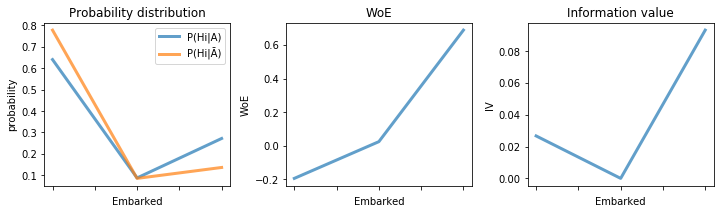

In [11]:
woe.plot()

In [12]:
pipeline.add(step=Preprocessing.Step(
    input_var='Embarked',
    transformations=[
        transform,
        lambda x, w=woe.dict: x.astype('str').map(w), # replace by woe value
    ],
    output_var='embarked_woe',
    info=woe.iv
))

### 3.6. Sex

In [13]:
feature = dataset['Sex']
woe.calculate(H = feature, A = y_true, woe_sorted=True)

Survived,Ā,А,P(Hi),P(Hi|Ā),P(Hi|A),posterior-odds,weight-of-evidence,information-value,conclusion
Sex,,,,,,,,,
male,468.0,109.0,0.647587,0.852459,0.318713,0.373875,-0.983833,0.525116,excellent
female,81.0,233.0,0.352413,0.147541,0.681287,4.61761,1.52988,0.816565,excellent
total,549.0,342.0,1.000000,1.000000,1.000000,,,1.341681,excellent


In [14]:
pipeline.add(step=Preprocessing.Step(
    input_var='Sex',
    transformations=[
        lambda x, w=woe.dict: x.astype('str').map(w), # replace by woe value
    ],
    output_var='sex_woe',
    info=woe.iv
))

### 3.7. Pclass

In [15]:
feature = dataset['Pclass']
woe.calculate(H = feature, A = y_true, woe_sorted=True)

Survived,Ā,А,P(Hi),P(Hi|Ā),P(Hi|A),posterior-odds,weight-of-evidence,information-value,conclusion
Pclass,,,,,,,,,
3,372.0,119.0,0.551066,0.677596,0.347953,0.513512,-0.666483,0.219701,medium
2,97.0,87.0,0.206510,0.176685,0.254386,1.43977,0.364485,0.028321,weak
1,80.0,136.0,0.242424,0.145719,0.397661,2.72895,1.00392,0.252928,medium
total,549.0,342.0,1.000000,1.000000,1.000000,,,0.500950,excellent


In [16]:
pipeline.add(step=Preprocessing.Step(
    input_var='Pclass',
    transformations=[
        lambda x, w=woe.dict: x.astype('str').map(w), # replace by woe value
    ],
    output_var='pclass_woe',
    info=woe.iv
))

### 3.8. Name

We need to extract title from name

In [17]:
# transform = lambda x: x.str.split(', ').str.get(1).str.split('.').str.get(0)
transform1 = lambda x: x.str.extract(' ([A-Za-z]+)\.', expand=False)

feature = transform1(dataset['Name'])
woe.calculate(H = feature, A = y_true, woe_sorted=True)

Survived,Ā,А,P(Hi),P(Hi|Ā),P(Hi|A),posterior-odds,weight-of-evidence,information-value,conclusion
Name,,,,,,,,,
Mr,436.0,81.0,0.580247,0.794171,0.236842,0.298225,-1.20991,0.674315,excellent
Capt,1.0,0.0,0.001122,0.001821,0.000000,0,0,-0.000000,useless
Ms,0.0,1.0,0.001122,0.000000,0.002924,inf,0,0.000000,useless
Mme,0.0,1.0,0.001122,0.000000,0.002924,inf,0,0.000000,useless
Mlle,0.0,2.0,0.002245,0.000000,0.005848,inf,0,0.000000,useless
Rev,6.0,0.0,0.006734,0.010929,0.000000,0,0,-0.000000,useless
Sir,0.0,1.0,0.001122,0.000000,0.002924,inf,0,0.000000,useless
Jonkheer,1.0,0.0,0.001122,0.001821,0.000000,0,0,-0.000000,useless
Don,1.0,0.0,0.001122,0.001821,0.000000,0,0,-0.000000,useless


We will replace rare titles

In [18]:
rare = ['Lady', 'Countess','the Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona']

In [19]:
transform2 = lambda x: x.replace(rare, 'rare')
transform3 = lambda x: x.replace(['Mlle','Ms','Mme'], 'Miss')

feature = transform3(transform2(feature))

In [20]:
woe.calculate(H = feature, A = y_true, woe_sorted=True)

Survived,Ā,А,P(Hi),P(Hi|Ā),P(Hi|A),posterior-odds,weight-of-evidence,information-value,conclusion
Name,,,,,,,,,
Mr,436.0,81.0,0.580247,0.794171,0.236842,0.298225,-1.20991,0.674315,excellent
rare,15.0,8.0,0.025814,0.027322,0.023392,0.85614,-0.155321,0.000611,useless
Master,17.0,23.0,0.044893,0.030965,0.067251,2.17183,0.775569,0.028142,weak
Miss,55.0,131.0,0.208754,0.100182,0.383041,3.82344,1.34115,0.379357,strong
Mrs,26.0,99.0,0.140292,0.047359,0.289474,6.11235,1.81031,0.438303,strong
total,549.0,342.0,1.000000,1.000000,1.000000,,,1.520728,excellent


In [21]:
pipeline.add(step=Preprocessing.Step(
    input_var='Name',
    transformations=[
        transform1, # extract title from name
        transform2, # replace rare titles
        transform3, # replace miss
        lambda x, w=woe.dict: x.astype('str').map(w), # replace by woe value
    ],
    output_var='title_woe',
    info=woe.iv
))

### 3.9. Sibsp +  Parch = Family

In [22]:
dataset['family'] = dataset['SibSp'] + dataset['Parch']

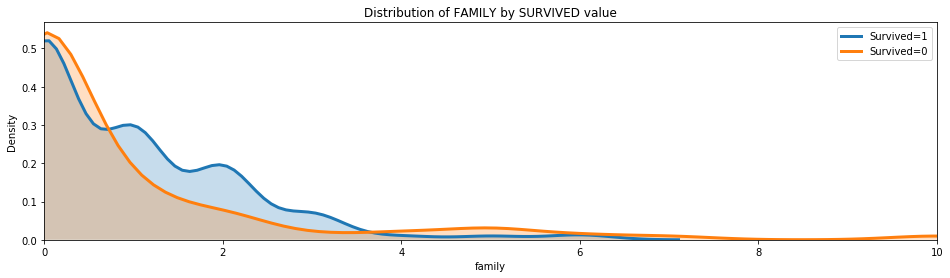

In [23]:
plot_density(data=dataset, feature='family', target='Survived')

We can manualy crate 3 groups. Alone - more chanse to die, small family - more chance to survive, and big family - to die

In [24]:
transform1 = lambda x: x.SibSp  + x.Parch
transform2 = lambda x: pd.cut(x, bins=[-np.inf,0,1,2,np.inf])

feature = transform2(transform1(dataset))
woe.calculate(H = feature, A = y_true, woe_sorted=True)

Survived,Ā,А,P(Hi),P(Hi|Ā),P(Hi|A),posterior-odds,weight-of-evidence,information-value,conclusion
row_0,,,,,,,,,
"(-inf, 0.0]",374.0,163.0,0.602694,0.681239,0.476608,0.69962,-0.357218,0.073098,weak
"(2.0, inf]",60.0,31.0,0.102132,0.109290,0.090643,0.829386,-0.18707,0.003488,useless
"(0.0, 1.0]",72.0,89.0,0.180696,0.131148,0.260234,1.98428,0.685258,0.088457,weak
"(1.0, 2.0]",43.0,59.0,0.114478,0.078324,0.172515,2.20257,0.789625,0.074375,weak
total,549.0,342.0,1.000000,1.000000,1.000000,,,0.239418,medium


In [25]:
pipeline.add(Preprocessing.Step(
    input_var=['SibSp', 'Parch'],
    transformations=[
        transform1, # sum two fields
        transform2, # # binning / discretization
        lambda x, w=woe.dict: x.astype('str').map(w), # replace by woe value
    ],
    output_var='family_bin_woe',
    info=woe.iv
))

### 3.10. Age

In Age we have missing values, which we can fill missing values by mean or median values

In [26]:
dataset.pivot_table(index='Pclass', values='Age', aggfunc=np.median)

,Age
Pclass,
1,37.0
2,29.0
3,24.0


In [27]:
dataset['Age'].fillna(dataset['Pclass'].map({1:39, 2:29, 3:24}), inplace=True)

Now we can see distribution

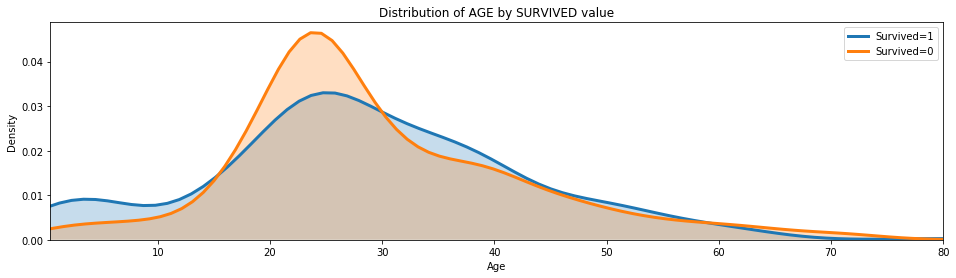

In [28]:
plot_density(data=dataset, target='Survived', feature='Age')

Again we see 4 group and it is better to bin manualy

In [29]:
transform1 = lambda x: x.Age.fillna(x.Pclass.map({1:39, 2:29, 3:24}))
transform2 = lambda x: pd.cut(x, bins=[-np.inf,8,15,30,58,np.inf])

feature = transform2(transform1(dataset))
woe.calculate(H = feature, A = y_true, woe_sorted=True)

Survived,Ā,А,P(Hi),P(Hi|Ā),P(Hi|A),posterior-odds,weight-of-evidence,information-value,conclusion
Age,,,,,,,,,
"(58.0, inf]",21.0,7.0,0.031425,0.038251,0.020468,0.535088,-0.625325,0.011120,useless
"(15.0, 30.0]",318.0,155.0,0.530864,0.579235,0.453216,0.78244,-0.245339,0.030917,weak
"(30.0, 58.0]",176.0,131.0,0.344557,0.320583,0.383041,1.19483,0.178001,0.011118,useless
"(8.0, 15.0]",16.0,13.0,0.032548,0.029144,0.038012,1.30428,0.265648,0.002356,useless
"(-inf, 8.0]",18.0,36.0,0.060606,0.032787,0.105263,3.21053,1.16643,0.084539,weak
total,549.0,342.0,1.000000,1.000000,1.000000,,,0.140050,medium


In [30]:
pipeline.add(Preprocessing.Step(
    input_var=['Age', 'Pclass'],
    transformations=[
        transform1, # fill missing values with median by Pclass
        transform2, # # binning / discretization
        lambda x, w=woe.dict: x.astype('str').map(w), # replace by woe value
    ],
    output_var='age_bin_woe',
    info=woe.iv
))

### 3.11. Fare

In [31]:
dataset['Fare'].isnull().sum()

0

In [32]:
dataset['Fare'].fillna(0, inplace=True)

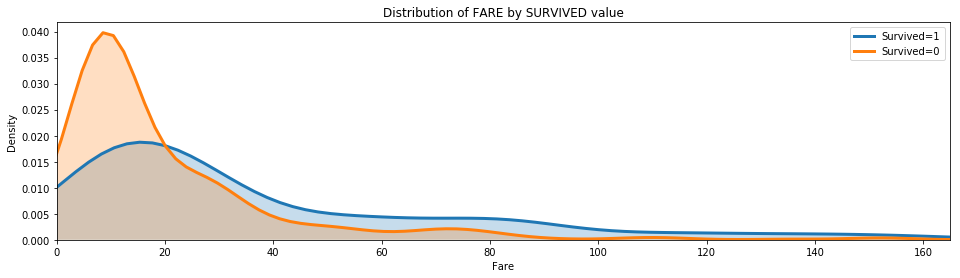

In [33]:
plot_density(data=dataset[dataset['Fare']<200], target='Survived', feature='Fare')
plt.show()

In [34]:
transform1 = lambda x: x.fillna(0)
transform2 = lambda x: pd.cut(x, bins=[-np.inf,20,40,80,np.inf])

feature = transform2(transform1(dataset['Fare']))
woe.calculate(H = feature, A = y_true, woe_sorted=True)

Survived,Ā,А,P(Hi),P(Hi|Ā),P(Hi|A),posterior-odds,weight-of-evidence,information-value,conclusion
Fare,,,,,,,,,
"(-inf, 20.0]",372.0,143.0,0.578002,0.677596,0.418129,0.617077,-0.482762,0.125261,medium
"(20.0, 40.0]",114.0,86.0,0.224467,0.207650,0.251462,1.21099,0.191437,0.008387,useless
"(40.0, 80.0]",46.0,56.0,0.114478,0.083789,0.163743,1.95423,0.669998,0.053569,weak
"(80.0, inf]",17.0,57.0,0.083053,0.030965,0.166667,5.38235,1.68313,0.228402,medium
total,549.0,342.0,1.000000,1.000000,1.000000,,,0.415619,strong


In [35]:
pipeline.add(Preprocessing.Step(
    input_var='Fare',
    transformations=[
        transform1, # fill missing values
        transform2, # # binning / discretization
        lambda x, w=woe.dict: x.astype('str').map(w), # replace by woe value
    ],
    output_var='fare_bin_woe',
    info=woe.iv
))

### 3.12. Gender + passenger class

In [36]:
transform = lambda x: x.Sex + '-' + x.Pclass.astype(str)

feature = transform(dataset)
woe.calculate(H = feature, A = y_true, woe_sorted=True)

Survived,Ā,А,P(Hi),P(Hi|Ā),P(Hi|A),posterior-odds,weight-of-evidence,information-value,conclusion
row_0,,,,,,,,,
male-3,300.0,47.0,0.389450,0.546448,0.137427,0.251491,-1.38035,0.564591,excellent
male-2,91.0,17.0,0.121212,0.165756,0.049708,0.299884,-1.20436,0.139764,medium
male-1,77.0,45.0,0.136925,0.140255,0.131579,0.938141,-0.0638552,0.000554,useless
female-3,72.0,72.0,0.161616,0.131148,0.210526,1.60526,0.473288,0.037569,weak
female-2,6.0,70.0,0.085297,0.010929,0.204678,18.7281,2.93002,0.567690,excellent
female-1,3.0,91.0,0.105499,0.005464,0.266082,48.693,3.88553,1.012638,excellent
total,549.0,342.0,1.000000,1.000000,1.000000,,,2.322806,excellent


In [37]:
pipeline.add(Preprocessing.Step(
    input_var=['Sex','Pclass'],
    transformations=[
        transform, # combine 2 variables
        lambda x, w=woe.dict: x.astype('str').map(w), # replace by woe value
    ],
    output_var='gender_plass_mix_woe',
    info=woe.iv
))

## 5. Feature selection

In [38]:
x_train = pipeline.transform(X=dataset)

### 5.1. Correlation analysis

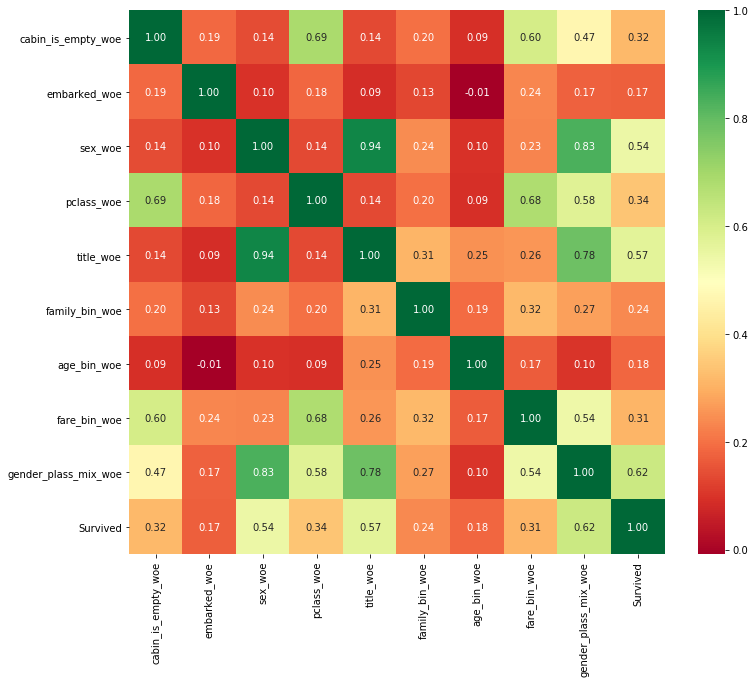

In [39]:
plt.figure(figsize = (12,10))
sns.heatmap(x_train.join(y_true).astype('float64').corr(), annot=True, cmap="RdYlGn", fmt=".2f")
plt.show()

### 5.2. Feature impotrance by inofrmation value

In [40]:
pipeline.info(
    keys=['information-value','conclusion'],
    sort_by='information-value'
)

,conclusion,feature,information-value
8,excellent,gender_plass_mix_woe,2.322806
4,excellent,title_woe,1.520728
2,excellent,sex_woe,1.341681
3,excellent,pclass_woe,0.500950
0,strong,cabin_is_empty_woe,0.421963
7,strong,fare_bin_woe,0.415619
5,medium,family_bin_woe,0.239418
6,medium,age_bin_woe,0.140050
1,medium,embarked_woe,0.119923


### 5.3. Single variable test by model

In [41]:
single_feature_test = pd.DataFrame()

for col in x_train.columns:
    i = x_train[col].values.reshape(-1, 1)
    logreg = LogisticRegression()
    logreg.fit(i, y_true)
    single_feature_test = single_feature_test.append({'feature':col, 'score':round(logreg.score(i, y_true) * 100, 2)}, ignore_index=True)

single_feature_test.sort_values('score', ascending=False)

,feature,score
4,title_woe,79.01
2,sex_woe,78.68
8,gender_plass_mix_woe,78.68
0,cabin_is_empty_woe,69.25
3,pclass_woe,67.90
7,fare_bin_woe,67.23
5,family_bin_woe,65.32
1,embarked_woe,63.64
6,age_bin_woe,63.64


### 5.4 Filter

Remove all steps with feature iv less 0.15

In [42]:
for key in pipeline._items.copy():
    i = pipeline._items[key].info.get('information-value')
    if i < 0.15:
        print(round(i,4), key)
        del pipeline._items[key]

0.1199 embarked_woe
0.14 age_bin_woe


In [43]:
x_train = pipeline.transform(X=dataset)

## 5. Modeling

In [44]:
x_train.isnull().sum().sort_values(ascending=False).compress(lambda x: x>0)

Series([], dtype: int64)

### 5.1. Base model (Logistic Regression)

In [45]:
model = LogisticRegression()
model.fit(x_train, y_true)
y_pred_proba = pd.Series(model.predict_proba(x_train)[:,1], name = 'y_pred_proba')
print('accuracy with 0.5 threshold: {}'.format(round(model.score(x_train, y_true) * 100, 2)))

accuracy with 0.5 threshold: 80.7


Choose custom threshold if distribution is skewed or if the task requires it

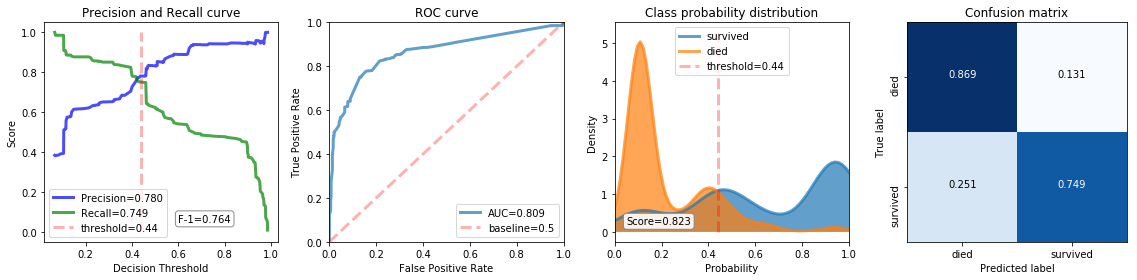

In [46]:
plot_model_summary(y_true, y_pred_proba, threshold=0.44,  class_labels = ['died','survived'])

In [47]:
coeff_df = pd.DataFrame(x_train.columns)
coeff_df.columns = ['feature']
coeff_df["coef"] = pd.Series(model.coef_[0])
coeff_df["odds"] = pd.Series(model.coef_[0]).apply(np.exp)
coeff_df.sort_values(by='odds', ascending=False)

,feature,coef,odds
6,gender_plass_mix_woe,0.979439,2.662962
3,title_woe,0.933629,2.543725
0,cabin_is_empty_woe,0.542299,1.719956
4,family_bin_woe,0.287814,1.333509
2,pclass_woe,-0.068272,0.934007
5,fare_bin_woe,-0.430828,0.649971
1,sex_woe,-0.879450,0.415011


### 5.2. Models benchmark

In [48]:
models = { 
        'logreg':LogisticRegression(),
        'random-forest': RandomForestClassifier(n_estimators=100),
        'svc': SVC(),
        'svc-linear': LinearSVC(),
        'knn': KNeighborsClassifier(n_neighbors = 6),
        'gradient-boosting': GradientBoostingClassifier(),
        'decission-tree': DecisionTreeClassifier(),
        'naive-bayes': GaussianNB(),
        'perceptron': Perceptron(max_iter=100),
        'sgd':SGDClassifier(max_iter=100),
        'lgmb': LGBMClassifier(),
    }
model_benchmark(x_train.astype('float64'),y_true,models).sort_values(by='cross-score', ascending=False).head(20)

,model,train-score,cross-score,auc
2,SVC,83.16,0.824 (+-0.010),0.843 (+-0.033)
4,KNeighborsClassifier,82.38,0.817 (+-0.014),0.860 (+-0.009)
10,LGBMClassifier,83.84,0.809 (+-0.006),0.852 (+-0.006)
1,RandomForestClassifier,84.85,0.805 (+-0.019),0.857 (+-0.009)
5,GradientBoostingClassifier,83.61,0.804 (+-0.009),0.849 (+-0.013)
6,DecisionTreeClassifier,84.85,0.801 (+-0.007),0.844 (+-0.016)
3,LinearSVC,81.37,0.792 (+-0.006),0.853 (+-0.013)
0,LogisticRegression,80.70,0.786 (+-0.010),0.849 (+-0.013)
9,SGDClassifier,80.25,0.777 (+-0.029),0.673 (+-0.262)
7,GaussianNB,77.55,0.776 (+-0.015),0.847 (+-0.006)


### 5.3 Select model

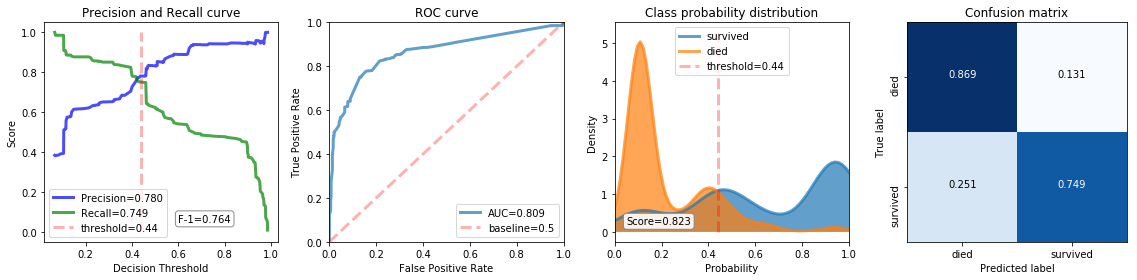

In [49]:
model = LogisticRegression()
# model = SVC(probability=True)
# model = LGBMClassifier()
# model = GradientBoostingClassifier()

model.fit(x_train, y_true)
y_pred_proba = pd.Series(model.predict_proba(x_train)[:,1], name = 'y_pred_proba')
plot_model_summary(y_true, y_pred_proba, threshold=0.44,  class_labels = ['died','survived'])

## 6. Model submission

In [50]:
test = pd.read_csv('./data/test.csv')
x_test = pipeline.transform(X=test)

In [51]:
test['Survived'] = predict_with_threshold(
                        y_pred_proba=model.predict_proba(x_test)[:,1], 
                        threshold=0.44)
result = test[['PassengerId','Survived']]

In [52]:
result.to_csv('./data/submission-{}.csv'.format(model.__class__.__name__), index=False)